In [1]:
!wmic path win32_VideoController get Caption,DeviceID,VideoProcessor

Caption                  DeviceID          VideoProcessor           

NVIDIA GeForce RTX 3070  VideoController1  NVIDIA GeForce RTX 3070  





In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

# 导入数据

In [3]:
dataset = pd.read_csv('Data/FLX_CN-Cha_PrePro.csv')

In [4]:
dataset.head()

,TIMESTAMP_START,SW_IN_F_F,SW_IN_F,TA_F_F,TA_F,LW_IN_F_F,LW_IN_F,VPD_F_F,VPD_F,PA_F_F,PA_F,WS_F_F,WS_F,RH_F,RH
0,2003/1/1 7:00,0.077672,2.367241,-20.92,-21.08,136.9,136.3,0.441,0.404,93.3,93.4,2.133,2.814,61.70,64.40
1,2003/1/1 7:30,2.367241,7.844828,-21.08,-20.82,136.3,135.1,0.404,0.408,93.4,93.4,2.814,1.794,64.40,64.84
2,2003/1/1 8:00,7.844828,14.956897,-20.82,-20.10,135.1,133.6,0.408,0.452,93.4,93.4,1.794,1.796,64.84,63.44
3,2003/1/1 8:30,14.956897,22.000000,-20.10,-19.05,133.6,133.8,0.452,0.537,93.4,93.4,1.796,2.193,63.44,60.31
4,2003/1/1 9:00,22.000000,27.956897,-19.05,-18.81,133.8,134.2,0.537,0.578,93.4,93.4,2.193,4.855,60.31,58.16


# 多变量进行预测

In [5]:
var_origin = dataset[['SW_IN_F_F','SW_IN_F','TA_F_F','TA_F','LW_IN_F_F','LW_IN_F','VPD_F_F','VPD_F','PA_F_F','PA_F','WS_F_F','WS_F','RH_F','RH']]
var_origin.head()

,SW_IN_F_F,SW_IN_F,TA_F_F,TA_F,LW_IN_F_F,LW_IN_F,VPD_F_F,VPD_F,PA_F_F,PA_F,WS_F_F,WS_F,RH_F,RH
0,0.077672,2.367241,-20.92,-21.08,136.9,136.3,0.441,0.404,93.3,93.4,2.133,2.814,61.70,64.40
1,2.367241,7.844828,-21.08,-20.82,136.3,135.1,0.404,0.408,93.4,93.4,2.814,1.794,64.40,64.84
2,7.844828,14.956897,-20.82,-20.10,135.1,133.6,0.408,0.452,93.4,93.4,1.794,1.796,64.84,63.44
3,14.956897,22.000000,-20.10,-19.05,133.6,133.8,0.452,0.537,93.4,93.4,1.796,2.193,63.44,60.31
4,22.000000,27.956897,-19.05,-18.81,133.8,134.2,0.537,0.578,93.4,93.4,2.193,4.855,60.31,58.16


### 数据进行归一化操作 当把值规定在-2到2时，预测结果迅速上升

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(var_origin)
# print(var_origin.columns)

#### Z-Score 归一化可以将数据缩放到均值为 0、标准差为 1 的范围内。这种归一化方法对于数据的分布没有假设，因此在数据的分布不确定时使用较为普遍。

In [7]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaled = scaler.fit_transform(var_origin)

Max Abs Scaler 归一化将数据缩放到[-1,1]范围内，缩放的方法是将数据除以最大值的绝对值。对于数据中有明显异常值或数据范围未知的情况下使用较为常见。

In [8]:
# from sklearn.preprocessing import MaxAbsScaler
# scaler = MaxAbsScaler()
# scaled = scaler.fit_transform(var_origin)


In [9]:
# from sklearn import preprocessing#进行归一化操作
# scaler = preprocessing.MinMaxScaler()
# scaled=scaler.fit_transform(var_origin)
# scaled = pd.DataFrame(scaled,columns=var_origin.columns)
# # 将 DataFrame 转换为 NumPy 数组
# scaled = scaled.to_numpy()

将数据转为cuda类型

In [10]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
var= torch.FloatTensor(scaled).to(device)

划分训练集，验证集和测试集

In [11]:
print(var[1:20])

tensor([[0.0270, 0.0650, 0.1195, 0.1196, 0.0527, 0.0489, 0.0130, 0.0131, 0.7111,
         0.7045, 0.3059, 0.1950, 0.6440, 0.6484],
        [0.0895, 0.1483, 0.1240, 0.1320, 0.0489, 0.0442, 0.0131, 0.0146, 0.7111,
         0.7045, 0.1950, 0.1952, 0.6484, 0.6344],
        [0.1707, 0.2308, 0.1363, 0.1501, 0.0442, 0.0448, 0.0146, 0.0173, 0.7111,
         0.7045, 0.1952, 0.2384, 0.6344, 0.6031],
        [0.2510, 0.3006, 0.1543, 0.1542, 0.0448, 0.0460, 0.0173, 0.0186, 0.7111,
         0.7045, 0.2384, 0.5277, 0.6031, 0.5816],
        [0.3190, 0.3665, 0.1584, 0.1577, 0.0460, 0.0501, 0.0186, 0.0200, 0.7111,
         0.7045, 0.5277, 0.5000, 0.5816, 0.5580],
        [0.3831, 0.4033, 0.1619, 0.1627, 0.0501, 0.0539, 0.0200, 0.0219, 0.7111,
         0.7045, 0.5000, 0.4363, 0.5580, 0.5270],
        [0.4190, 0.4426, 0.1668, 0.1659, 0.0539, 0.0574, 0.0219, 0.0243, 0.7111,
         0.7045, 0.4363, 0.5055, 0.5270, 0.4841],
        [0.4572, 0.4440, 0.1701, 0.1703, 0.0574, 0.0602, 0.0243, 0.0259, 0.7111,
  

In [12]:
def splitData(var,per_val,per_test):
    num_val=int(len(var)*per_val)
    num_test=int(len(var)*per_test)
    train_size=int(len(var)-num_val-num_test)
    train_data=var[0:train_size]
    val_data=var[train_size:train_size+num_val]
    test_data=var[train_size+num_val:train_size+num_val+num_test]
    return train_data,val_data,test_data

In [13]:
# import numpy as np
# from collections import Counter
# import seaborn as sns
# import matplotlib.pyplot as plt
#
# def under_sampling(X, y, ratio=1.0):
#     """
#     欠采样函数，输入特征矩阵 X 和标签向量 y，输出欠采样后的特征矩阵和标签向量
#     ratio：欠采样后多数类别样本数量与少数类别样本数量的比例，默认为 1.0，即不做任何处理
#     """
#     # 统计各类别样本数量
#     counter = Counter(y)
#     majority_class = max(counter, key=counter.get)
#     minority_class = min(counter, key=counter.get)
#     n_majority = counter[majority_class]
#     n_minority = counter[minority_class]
#
#     # 计算欠采样后的多数类别样本数量
#     n_majority_new = int(n_minority * ratio)
#
#     # 从多数类别样本中随机选择一部分样本
#     idx_majority = np.where(y == majority_class)[0]
#     idx_majority_new = np.random.choice(idx_majority, size=n_majority_new, replace=False)
#
#     # 构造新的特征矩阵和标签向量
#     X_new = np.vstack((X[idx_majority_new], X[y == minority_class]))
#     y_new = np.hstack((y[idx_majority_new], y[y == minority_class]))
#
#     return X_new, y_new


我们的验证集合测试集都取10%

In [14]:
train_data,val_data,test_data=splitData(var,0.1,0.1)

# 获取标签
#
# train_labels = np.where(train_data[:,7] == 0, 0, 1)  # 如果第一列（TA_F）为0，标签为0，否则为1
# print(train_labels[3000:4000])

In [15]:
# 对训练集进行欠采样
# X_train_res, y_train_res = under_sampling(train_data, train_labels, ratio=0.5)

查看长度

In [16]:
print('The length of train data, validation data and test data are:',len(train_data),',',len(val_data),',',len(test_data))

The length of train data, validation data and test data are: 19138 , 2392 , 2392


### 查看训练集以及测试集是否在一同一分布下

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_6896\2395731279.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_data.cpu(), hist=True, kde=False, label='Train Data')
C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_6896\2395731279.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(val_data

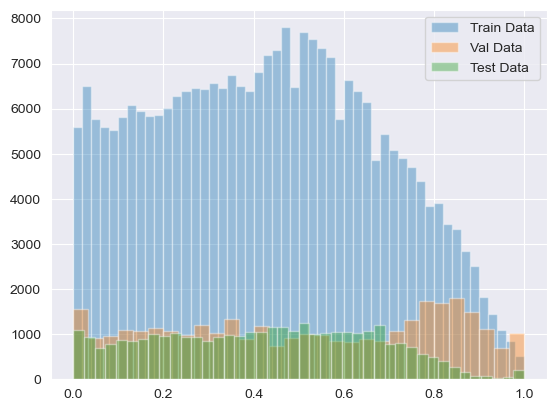

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# 绘制直方图
sns.distplot(train_data.cpu(), hist=True, kde=False, label='Train Data')
sns.distplot(val_data.cpu(), hist=True, kde=False, label='Val Data')
sns.distplot(test_data.cpu(), hist=True, kde=False, label='Test Data')

plt.legend()
plt.show()


取一定大小的窗口进行滑动，每个窗口的label值是窗口下一个预测的第一个空气污染物的值

In [18]:
train_window = 1
def create_train_sequence(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [19]:
train_inout_seq = create_train_sequence(train_data, train_window)
print(len(train_data))
print('The total number of train windows is',len(train_inout_seq))

19138
The total number of train windows is 19137


注意，与上面创建train_data的sequence不同，验证集数据(实验是96个验证集数据)只是label。其数据部分还是需要借助于train集中的数据，大小为一个窗口。而这一个窗口的数据并不会在训练过程中被使用

In [20]:
def create_val_sequence(train_data,val_data, tw):
    temp=torch.cat((train_data,val_data))   #先将训练集和测试集合并
    inout_seq = []
    L = len(val_data)
    for i in range(L):
        val_seq = temp[-(train_window+L)+i:-L+i]
        val_label = test_data[i:i+1]
        inout_seq.append((val_seq ,val_label))

    return inout_seq

val_inout_seq = create_val_sequence(train_data, val_data,train_window)
print('The total number of validation windows is',len(val_inout_seq))

The total number of validation windows is 2392


In [21]:
def create_test_sequence(train_data,val_data,test_data, tw):
    temp=torch.cat((train_data,val_data))   #先将训练集和测试集合并
    temp=torch.cat((temp,test_data))
    inout_seq = []
    L = len(test_data)
    for i in range(L):
        test_seq = temp[-(train_window+L)+i:-L+i]
        test_label = test_data[i:i+1]
        inout_seq.append((test_seq ,test_label))

    return inout_seq

test_inout_seq = create_test_sequence(train_data, val_data, test_data,train_window)

print('The total number of validation windows is',len(val_inout_seq))

The total number of validation windows is 2392


# 定义LSTM

与单变量lstm不同的是，这次的数据的维度为8维，而单变量只有1维

In [22]:
train_data.shape

torch.Size([19138, 14])

In [29]:
import math
from torch import nn
import torch.nn.init as init
import torch.nn.functional as F
class LSTM(nn.Module):
    def __init__(self,input_size=14,hidden_layer_size=22,output_size=1,num_layers=1):
        super().__init__()
        self.hidden_layer_size=hidden_layer_size
        self.lstm=nn.LSTM(input_size,hidden_layer_size,num_layers)
        self.linear1=nn.Linear(hidden_layer_size,hidden_layer_size)
        self.linear2=nn.Linear(hidden_layer_size,output_size)
        self.dropout = nn.Dropout(0.1)
        self.hidden_cell=(torch.zeros(num_layers,1,self.hidden_layer_size),torch.zeros(num_layers,1,self.hidden_layer_size))
        init_rnn(self.lstm,'xavier')
        
    def forward(self,input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.reshape(len(input_seq),1,14), self.hidden_cell)
        out = self.dropout(lstm_out)
        out=self.linear1(lstm_out.view(len(input_seq), -1))
        out=torch.tanh(out)
        predictions = self.linear2(out)
        return predictions[-1]


#设定初始化
def init_rnn(x, type='uniform'):
    for layer in x._all_weights:
        for w in layer:
            if 'weight' in w:
                if type == 'xavier':
                    init.xavier_normal_(getattr(x, w))
                elif type == 'uniform':
                    stdv = 1.0 / math.sqrt(x.hidden_size)
                    init.uniform_(getattr(x, w), -stdv, stdv)
                elif type == 'normal':
                    stdv = 1.0 / math.sqrt(x.hidden_size)
                    init.normal_(getattr(x, w), .0, stdv)
                else:
                    raise ValueError


In [30]:
import numpy as np
print(var_origin.columns.values[0])
col_name = var_origin.columns.values
print(col_name)

model_array = []
optimize_arry = []
for i in range(len(col_name)):
    temp = 'model_'+'{}'.format(col_name[i])
    temp2 = 'optimizer_'+'{}'.format(col_name[i])
    model_array.append(temp)
    optimize_arry.append(temp2)
print(model_array,optimize_arry)

SW_IN_F_F
['SW_IN_F_F' 'SW_IN_F' 'TA_F_F' 'TA_F' 'LW_IN_F_F' 'LW_IN_F' 'VPD_F_F'
 'VPD_F' 'PA_F_F' 'PA_F' 'WS_F_F' 'WS_F' 'RH_F' 'RH']
['model_SW_IN_F_F', 'model_SW_IN_F', 'model_TA_F_F', 'model_TA_F', 'model_LW_IN_F_F', 'model_LW_IN_F', 'model_VPD_F_F', 'model_VPD_F', 'model_PA_F_F', 'model_PA_F', 'model_WS_F_F', 'model_WS_F', 'model_RH_F', 'model_RH'] ['optimizer_SW_IN_F_F', 'optimizer_SW_IN_F', 'optimizer_TA_F_F', 'optimizer_TA_F', 'optimizer_LW_IN_F_F', 'optimizer_LW_IN_F', 'optimizer_VPD_F_F', 'optimizer_VPD_F', 'optimizer_PA_F_F', 'optimizer_PA_F', 'optimizer_WS_F_F', 'optimizer_WS_F', 'optimizer_RH_F', 'optimizer_RH']


# 训练模型

在训练模型我们需要了解到，该实验是变量预测单变量，根据单变量数量进行多次预测。。。比方说，我们现在有8个attributes,用来预测1个attribute(比如nox)。。。刚开始我是准备8个attributes预测8个attributes，但是实验结果真的是太差了，还不如单变量预测单变量。。。

In [31]:
import copy

epochs=20

#['Ra','SW_IN_F','TA_F','WS_F','TA_D','RH','dswrf','gust','spfh','tmax','tmin']
#[['TA_F','SW_IN_POT','SW_IN_F','LW_IN_F','VPD_F','PA_F','P_F','WS_F','LE_F_MDS','H_F_MDS']].values
#为了实现多变量预测多个单变量，我这里用了五个LSTM模型
# var_origin = dataset[['TA_F','LW_IN_F','VPD_F','PA_F','WS_F','LE_F_MDS','H_F_MDS']].values
# SW_IN_Fx_Rax SW_IN_Fx Rax Ra SW_IN_F TA_F WS_F TA_D RH dswrf gust spfh tmax tmin

loss_function=nn.MSELoss()
for i in range(len(model_array)):
    model_array[i] = LSTM().to(device)
    # optimize_arry[i] = torch.optim.SGD(model_array[i].parameters(),lr=0.03,momentum=0.4,weight_decay=6e-4)
    # optimize_arry[i] = torch.optim.SGD(model_array[i].parameters(),lr=1e-2,momentum=0.9,weight_decay=1e-4)
    optimize_arry[i] = torch.optim.Adam(model_array[i].parameters(),lr=0.001)


# model_SW_IN_Fx_Rax =LSTM().to(device)
# model_SW_IN_Fx=LSTM().to(device)
# model_Rax =LSTM().to(device)
# model_Ra =LSTM().to(device)
# model_SW_IN_F =LSTM().to(device)
# model_TA_F =LSTM().to(device)
# model_WS_F=LSTM().to(device)
# model_TA_D=LSTM().to(device)
# model_RH=LSTM().to(device)
# model_dswrf=LSTM().to(device)
# model_gust=LSTM().to(device)
# model_spfh=LSTM().to(device)
# model_tmax=LSTM().to(device)
# model_tmin=LSTM().to(device)
# # model_SW_IN_POT=LSTM().to(device)
# # model_SW_IN_F=LSTM().to(device)
# # model_LW_IN_F=LSTM().to(device)
# # model_VPD_F=LSTM().to(device)
# # model_PA_F=LSTM().to(device)
# # model_P_F=LSTM().to(device)
#
# # model_LE_F_MDS=LSTM().to(device)
# # model_H_F_MDS=LSTM().to(device)
# #model_spfh=LSTM().to(device)
# #model_tmax=LSTM().to(device)
# #model_tmin=LSTM().to(device)

# loss_function=nn.MSELoss()
# #SGD 参数优化算法
# optimizer_SW_IN_Fx_Rax = torch.optim.SGD(model_SW_IN_Fx_Rax.parameters(),lr=0.03,momentum=0.4, weight_decay=6e-4)
# optimizer_SW_IN_Fx = torch.optim.SGD(model_SW_IN_Fx.parameters(),lr=0.03,momentum=0.2, weight_decay=6e-4)
# optimizer_Rax = torch.optim.SGD(model_Rax.parameters(),lr=0.03,momentum=0.2, weight_decay=6e-4)
# optimizer_Ra = torch.optim.SGD(model_Ra.parameters(),lr=0.03,momentum=0.4, weight_decay=6e-4)
# optimizer_SW_IN_F = torch.optim.SGD(model_SW_IN_F.parameters(),lr=0.03,momentum=0.2, weight_decay=6e-4)
# optimizer_TA_F = torch.optim.SGD(model_TA_F.parameters(),lr=0.03,momentum=0.4, weight_decay=6e-4)
# optimizer_WS_F = torch.optim.SGD(model_WS_F.parameters(),lr=0.03,momentum=0.2, weight_decay=6e-4)
# optimizer_TA_D = torch.optim.SGD(model_TA_D.parameters(),lr=0.03,momentum=0.2, weight_decay=6e-4)
# optimizer_RH = torch.optim.SGD(model_RH.parameters(),lr=0.03,momentum=0.2, weight_decay=6e-4)
# optimizer_dswrf = torch.optim.SGD(model_dswrf.parameters(),lr=0.02,momentum=0.2, weight_decay=6e-4)
# optimizer_gust = torch.optim.SGD(model_gust.parameters(),lr=0.02,momentum=0.2, weight_decay=6e-4)
# optimizer_spfh = torch.optim.SGD(model_spfh.parameters(),lr=0.02,momentum=0.2, weight_decay=6e-4)
# optimizer_tmax = torch.optim.SGD(model_tmax.parameters(),lr=0.02,momentum=0.2, weight_decay=6e-4)
# optimizer_tmin = torch.optim.SGD(model_tmin.parameters(),lr=0.02,momentum=0.2, weight_decay=6e-4)
#optimizer_SW_IN_POT = torch.optim.SGD(model_SW_IN_POT.parameters(), lr=0.03,momentum=0.4, weight_decay=6e-4)
#optimizer_SW_IN_F = torch.optim.SGD(model_SW_IN_F.parameters(), lr=0.02,momentum=0.4, weight_decay=6e-4)
# optimizer_LW_IN_F = torch.optim.SGD(model_LW_IN_F.parameters(), lr=0.03,momentum=0.4, weight_decay=6e-4)
# optimizer_VPD_F = torch.optim.SGD(model_VPD_F.parameters(), lr=0.03,momentum=0.4, weight_decay=6e-4)
# optimizer_PA_F = torch.optim.SGD(model_PA_F.parameters(), lr=0.03,momentum=0.4, weight_decay=6e-4)
# # optimizer_P_F = torch.optim.SGD(model_P_F.parameters(), lr=0.02,momentum=0.2, weight_decay=6e-4)
# optimizer_WS_F = torch.optim.SGD(model_WS_F.parameters(), lr=0.03,momentum=0.4, weight_decay=6e-4)
# optimizer_LE_F_MDS= torch.optim.SGD(model_LE_F_MDS.parameters(), lr=0.03,momentum=0.4, weight_decay=6e-4)
# optimizer_H_F_MDS = torch.optim.SGD(model_H_F_MDS.parameters(), lr=0.03,momentum=0.4, weight_decay=6e-4)
#optimizer_spfh = torch.optim.SGD(model_spfh.parameters(), lr=0.03,momentum=0.2, weight_decay=6e-4)
#optimizer_tmax = torch.optim.SGD(model_tmax.parameters(), lr=0.03,momentum=0.2, weight_decay=6e-4)
#optimizer_tmin = torch.optim.SGD(model_tmin.parameters(), lr=0.03,momentum=0.2, weight_decay=6e-4)
# SW_IN_Fx_Rax SW_IN_Fx Rax Ra SW_IN_F TA_F WS_F TA_D RH dswrf gust spfh tmax tmin


attr_dic={

    col_name[0]:model_array[0],
    col_name[1]:model_array[1],

}

index_dic={
    col_name[0]:0,
    col_name[1]:1,

}

optimizer_dic={
    col_name[0]:optimize_arry[0],
    col_name[1]:optimize_arry[1],

}

loss_train_dic={
    col_name[0]:[],
    col_name[1]:[],

}

loss_val_dic={
    col_name[0]:[],
    col_name[1]:[],

}

value_train_dic={
    col_name[0]:[],
    col_name[1]:[],

}

value_val_dic={
    col_name[0]:[],
    col_name[1]:[],

}

In [32]:
def train_model(attr,model):
  model.train()
  print('训练',attr,'模型')
  for i in range(epochs):
    #train
    add=0
    for seq,label in train_inout_seq:   
        optimizer_dic[attr].zero_grad()
        seq=seq.to(device)
        label=label.to(device)
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).to(device),torch.zeros(1, 1, model.hidden_layer_size).to(device))
        y_pred = model(seq)

        if(i==epochs-1):  #对最后一次epoch的值进行记录
          value_train_dic[attr].append(y_pred)

        single_loss = loss_function(y_pred[0], label[0,index_dic[attr]])   #这里只预测label[i]的数值，即某个单一的空气污染物
        add+=single_loss
        single_loss .backward()
        optimizer_dic[attr].step()
    loss_train=add/len(train_inout_seq)
    loss_train_dic[attr].append(loss_train)


    #val
    add=0 
    t=0

    val_inputs=train_data[-train_window:]
    fut_pred = len(val_data)

    for seq,label in val_inout_seq:
      with torch.no_grad():
        seq = val_inputs[-train_window:].to(device)
        label=label.to(device)
        y_pred=model(seq)
        single_loss=loss_function(y_pred[0],label[0,index_dic[attr]])  

        add+=single_loss

        if(i==epochs):  #对最后一次epoch的值进行记录
          value_val_dic[attr].append(y_pred)

        #这一步可能比较模糊。首先我们要明确一点的是，y_pred是一个常数。但是我们的val的是nx8维的数。也就是一个
        #数据就有8维。我们对val_inputs的更新实际上是应该更新8维的数。可因为我们是多变量预测单变量，我们每次只是预测一个值
        #所以，解决方法就是，我先把未来的验证集里的8个数添加进去。然后用得出来的值取覆盖相应污染物的值
        temp=copy.deepcopy(val_data[t])
        # temp[index_dic[attr]]=y_pred
        temp=temp.view(1,-1)
        
        val_inputs=torch.cat((val_inputs,temp),0)
        t+=0

    loss_val=add/len(val_inout_seq)
    loss_val_dic[attr].append(loss_val)

    print(f'epoch: {i:3}  train_loss:{loss_train:10.8f} val_loss:{loss_val:10.8f}')
  print('----------------------')

In [33]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

import math


def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100


def test_model(attr, model):
    temp = torch.cat((train_data, val_data))
    test_inputs = temp[-train_window:, :]

    fut_pred = len(test_data)
    test_list = []
    test_results = copy.deepcopy(test_data)

    model.eval()

    for i in range(fut_pred):
        seq = test_inputs[-train_window:].to(device)
        with torch.no_grad():
            model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                            torch.zeros(1, 1, model.hidden_layer_size))
            y_pred = model(seq)
            temp = copy.deepcopy(test_data[i]).view(1, -1)
            # temp[index_dic[attr]]=y_pred
            # temp=temp.view(1,-1)
            test_inputs = torch.cat((test_inputs, temp), 0)
            test_results[i] = y_pred

    actual_predictions = scaler.inverse_transform(np.array(test_results.cpu()))

    x = np.arange(len(train_data) + len(val_data), len(dataset), 1)
    plt.figure(figsize=(8, 6))
    plt.grid(True)

    plt.plot(dataset.loc[len(dataset) - len(test_data):, attr].values, color="red", label='real value')
    plt.plot(actual_predictions[:, index_dic[attr]], label='prediction')

    plt.title('hours vs ' + attr + ' train set')
    plt.ylabel(attr)
    plt.xlabel('hour')

    plt.legend(loc='upper right', fontsize=15)

    y_true = dataset.loc[len(dataset) - len(test_data):, attr].values
    y_pred = actual_predictions[:, index_dic[attr]]

    y_data=pd.concat([pd.DataFrame(y_true),pd.DataFrame(y_pred)],axis=1)

    #y_data.to_csv('a.csv',index=False)

    r2 = r2_score(y_true, y_pred)
    print('mse: ', mean_squared_error(y_true, y_pred))
    print('mae: ', mean_absolute_error(y_true, y_pred))
    print("R2：", r2)

    textstr = '\n'.join((
        'R² : {:.5f}'.format(r2),
        'MAE : {:.5f}'.format(mean_absolute_error(y_true, y_pred)),
        'MSE : {:.5f}'.format(mean_squared_error(y_true, y_pred)),
        'MAPE : {:.5f}'.format(mape(y_true, y_pred))))


    props = dict(boxstyle='round', facecolor='wheat', alpha=0.1)

    plt.text(0.05, 0.97, textstr, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=props)
    # plt.savefig('Test_SW_IN_F_Train_Set_w_+'+'{}'.format(train_window)+'.png')

In [34]:
%%time
train_model(col_name[1],model_array[1])

训练 SW_IN_F 模型
epoch:   0  train_loss:0.01000155 val_loss:0.20410255
epoch:   1  train_loss:0.00879473 val_loss:0.21719006
epoch:   2  train_loss:0.00852888 val_loss:0.22276209
epoch:   3  train_loss:0.00831941 val_loss:0.23510632
epoch:   4  train_loss:0.00814573 val_loss:0.25125083
epoch:   5  train_loss:0.00800031 val_loss:0.26441830
epoch:   6  train_loss:0.00789038 val_loss:0.26636517
epoch:   7  train_loss:0.00781023 val_loss:0.26237565
epoch:   8  train_loss:0.00775031 val_loss:0.25048903
epoch:   9  train_loss:0.00770254 val_loss:0.24012843
epoch:  10  train_loss:0.00766832 val_loss:0.22947378
epoch:  11  train_loss:0.00763922 val_loss:0.22072622
epoch:  12  train_loss:0.00761284 val_loss:0.21343035
epoch:  13  train_loss:0.00758833 val_loss:0.20648669
epoch:  14  train_loss:0.00756625 val_loss:0.19967917
epoch:  15  train_loss:0.00754522 val_loss:0.19327551
epoch:  16  train_loss:0.00752369 val_loss:0.18845794
epoch:  17  train_loss:0.00750141 val_loss:0.18431878
epoch:  18  tr

mse:  104.73337385364624
mae:  8.221365674553374
R2： 0.6988927326090308


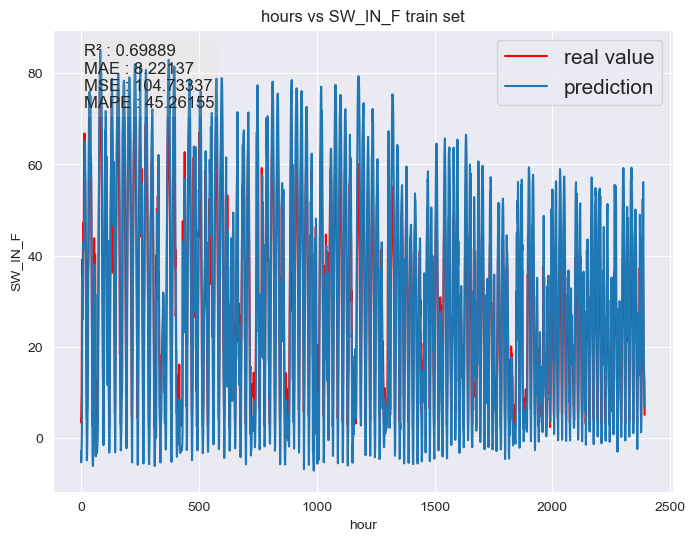

In [35]:
# %%time
test_model(col_name[1],model_array[1]) #为什么预测结果那么差？难道是说，作为深度学习来说，不适合少量数据的计算，或者是深度学习还没有学会，就结束了，数据不够用，导致不能够很好的预测？

In [37]:
def predict_future(attr,model):
  def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

  temp=torch.cat((train_data,val_data))
  test_inputs=temp[-train_window:,:]

  fut_pred = 300
  test_list=[]
  test_results=copy.deepcopy(test_data)

  model.eval()

  for i in range(fut_pred):
      seq = test_inputs[-train_window:].to(device)
      with torch.no_grad():
          model.hidden = (torch.zeros(2, 1, model.hidden_layer_size),
                          torch.zeros(2, 1, model.hidden_layer_size))
          y_pred=model(seq)
          temp=copy.deepcopy(test_data[i])
          # temp[index_dic[attr]]=y_pred
          temp=temp.view(1,-1)
          test_inputs=torch.cat((test_inputs,temp),0)
          test_results[i]=y_pred




  actual_predictions = scaler.inverse_transform(np.array(test_results.cpu()))





  plt.figure(figsize=(8, 6))
  plt.grid(True)

  plt.plot(dataset.loc[len(dataset)-len(test_data):len(dataset)-len(test_data)+fut_pred,attr].values,color="red",label='real value')
  plt.plot(actual_predictions[:fut_pred,index_dic[attr]],label='prediction')

  plt.title('hours vs '+attr+ ' test set')
  plt.ylabel(attr)
  plt.xlabel('hour')

  plt.legend(loc='upper right',fontsize=15)

  y_true=dataset.loc[len(dataset)-len(test_data):len(dataset)-len(test_data)+fut_pred-1,attr].values
  y_pred=actual_predictions[:fut_pred,index_dic[attr]]
  r2 = r2_score(y_true, y_pred)
  print('mse: ',mean_squared_error(y_true, y_pred))
  print('rmse: ',np.sqrt(mean_squared_error(y_true, y_pred)))
  print('mae: ',mean_absolute_error(y_true, y_pred))
  print("R2：", r2)

  textstr = '\n'.join((
        'R² : {:.5f}'.format(r2),
        'MAE : {:.5f}'.format(mean_absolute_error(y_true, y_pred)),
        'MSE : {:.5f}'.format(mean_squared_error(y_true, y_pred)),
        'MAPE : {:.5f}'.format(mape(y_true, y_pred))))


  props = dict(boxstyle='round', facecolor='wheat', alpha=0.1)

  plt.text(0.05, 0.97, textstr, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=props)
  # plt.savefig('SW_IN_F_Test_Set_w_'+'{}'.format(train_window)+'.png')
  y_pred=pd.DataFrame(y_pred)
  y_true=pd.DataFrame(y_true)
  y_pred.to_csv('PredictionResult/SW_TA_LW_VPD_PA_WS_RH/'+'LSTM_Multivar_SW_YPre_'+attr+'.csv',index=False)
  y_true.to_csv('PredictionResult/SW_TA_LW_VPD_PA_WS_RH/'+'LSTM_Multivar_SW_YTrue_'+attr+'.csv',index=False)

mse:  113.39132230005227
rmse:  10.648536157615856
mae:  8.502037174801941
R2： 0.7837316441741167


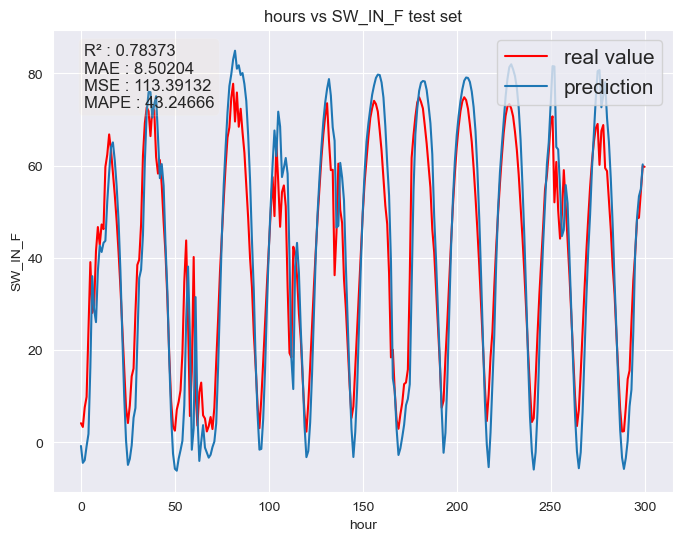

In [38]:
predict_future(col_name[1],model_array[1])